In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.patches import Patch

In [3]:
fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('d')

In [4]:
df_series = pd.read_csv("../procData/dataset_medias_tramos_max_mean_min.csv")


## HMM

In [5]:
from hmmlearn.hmm import GaussianHMM
import numpy as np

# Suponiendo que tu DataFrame se llama df_series_multivariadas
X = df_series.values

# Cada fila es una secuencia de 8 observaciones (una por día) de dimensión 3
# Reshape a (n_observaciones_totales, n_features)
# Número de series = 58, días por serie = 8 → total 464 días
X_reshaped = X.reshape(-1, 3)  # (464, 3)

# Lista con longitudes de cada secuencia (cada una tiene 8 días)
lengths = [8] * len(df_series)


In [6]:
n_estados = 2

modelo = GaussianHMM(n_components=n_estados, covariance_type='full', n_iter=500, random_state=42)
modelo.fit(X_reshaped, lengths)


GaussianHMM(covariance_type='full', n_components=2, n_iter=500, random_state=42)

In [7]:
estados = modelo.predict(X_reshaped, lengths)

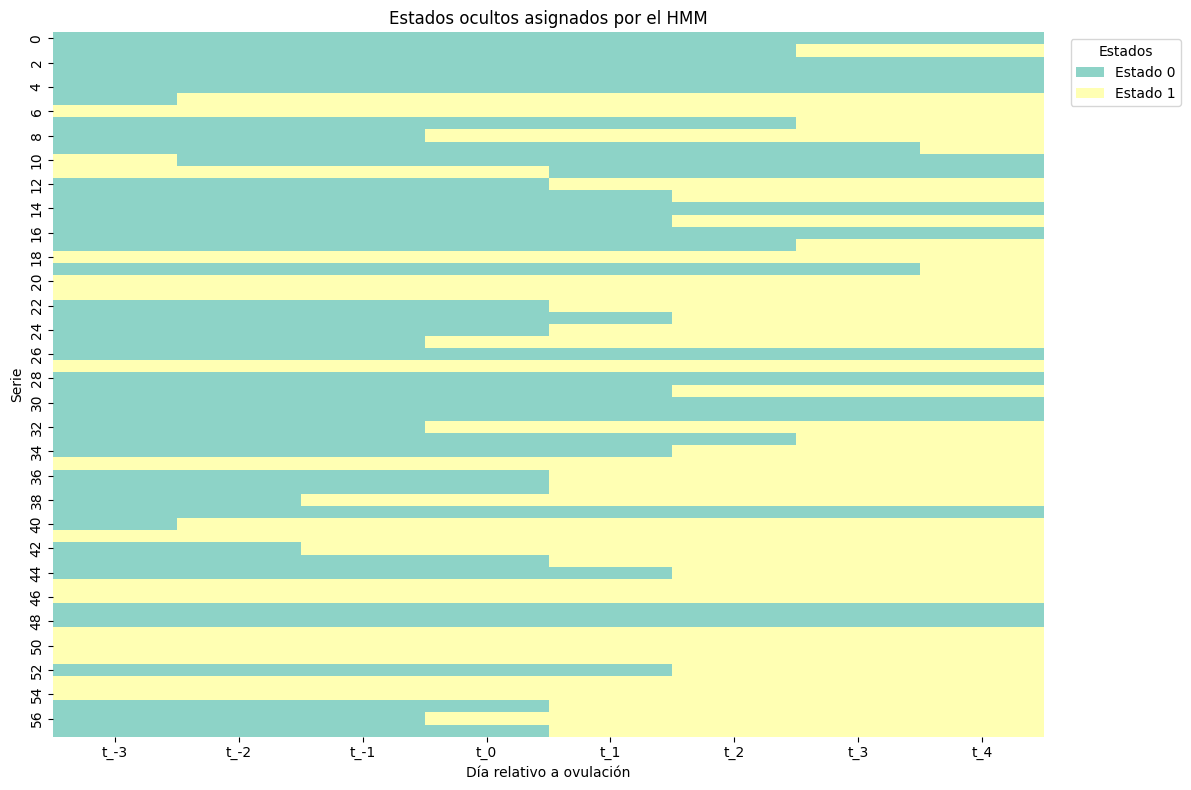

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reconstruimos el array (58 series × 8 días)
estados_series = np.array_split(estados, len(lengths))
estados_matrix = np.vstack(estados_series)

# Número de estados aprendidos por el modelo
num_estados = modelo.n_components

# Etiquetas para el eje x
dias_labels = [f"t_{i}" for i in range(-3, 5)]

# Colores definidos para cada estado
cmap = sns.color_palette("Set3", num_estados)

# Crear mapa de calor sin barra de color automática
plt.figure(figsize=(12, 8))
ax = sns.heatmap(estados_matrix, cmap=cmap, cbar=False, xticklabels=dias_labels)

plt.xlabel("Día relativo a ovulación")
plt.ylabel("Serie")
plt.title("Estados ocultos asignados por el HMM")

# Añadir leyenda personalizada con los estados reales

leyenda = [Patch(facecolor=cmap[i], label=f"Estado {i}") for i in range(num_estados)]
plt.legend(handles=leyenda, title="Estados", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


## Detección de puntos de ruptura

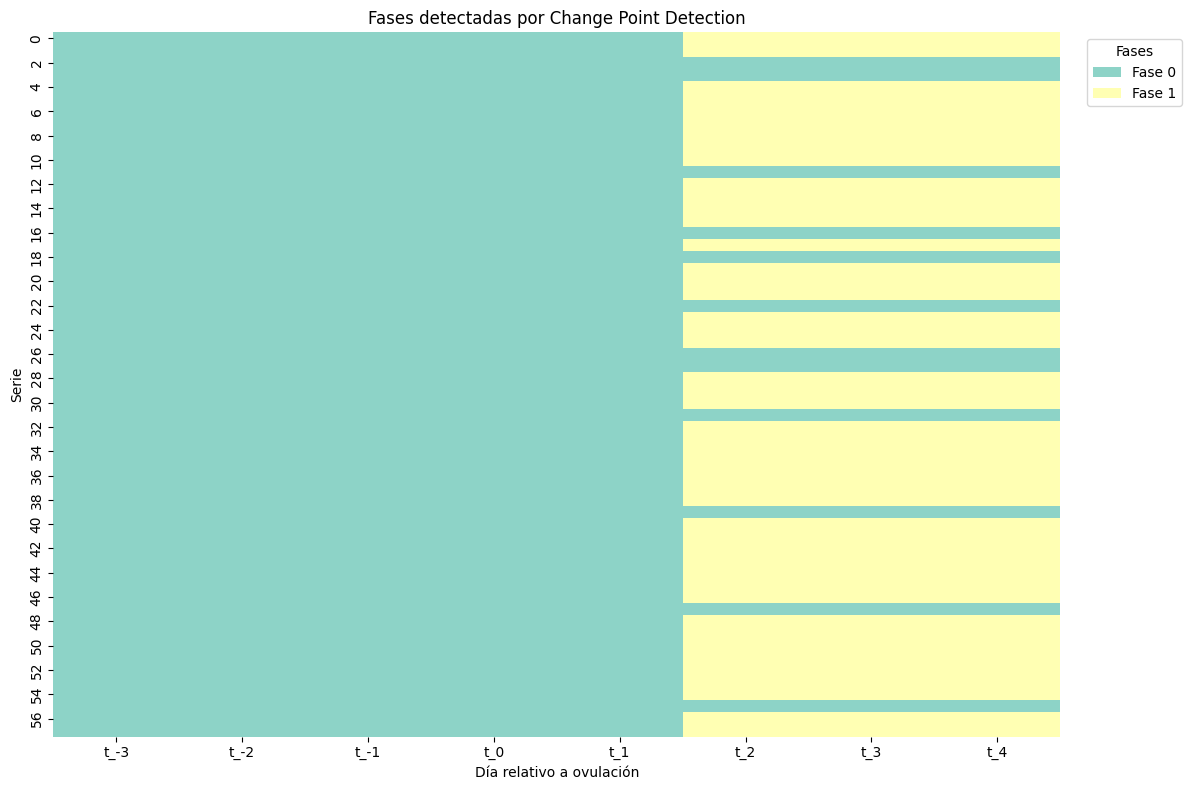

In [ ]:
import ruptures as rpt

# df: tu DataFrame con 58 filas (series) y 24 columnas (8 días × 3 variables: max, mean, min)
# Ejemplo de nombres: t_0_max, t_0_mean, t_0_min, ..., t_7_max, t_7_mean, t_7_min

num_series = df_series.shape[0]
num_days = 8
variables_per_day = 3  # max, mean, min

# Convertir cada fila en una matriz (num_days, variables_per_day)
series_data = [df_series.iloc[i].values.reshape(num_days, variables_per_day) for i in range(num_series)]

# Detectar puntos de cambio por serie
all_cps = []
penalizacion = 0.01  # ajustar para más/fewer cambios detectados
num_cambios = 1

for serie in series_data:
    algo = rpt.Pelt(model="l2").fit(serie) # rbf, l2, normal
    cps = algo.predict(pen=penalizacion)
    #algo = rpt.Binseg(model="normal").fit(serie)
    #cps = algo.predict(n_bkps=num_cambios)
    all_cps.append(cps)

# Crear matriz para fases: filas=series, columnas=días, valores=fase (estado entre puntos de cambio)
phases_matrix = np.zeros((num_series, num_days), dtype=int)

for i, cps in enumerate(all_cps):
    start = 0
    for phase_id, end in enumerate(cps):
        # end es índice +1, pero en Python es exclusivo, así que ajustamos:
        end_idx = min(end, num_days)
        phases_matrix[i, start:end_idx] = phase_id
        start = end_idx

# Etiquetas de días relativos
dias_labels = [f"t_{i}" for i in range(-3, 5)]

# Crear paleta de colores según número de fases detectadas
num_fases = phases_matrix.max() + 1
cmap = sns.color_palette("Set3", num_fases)

# Dibujar heatmap sin barra automática
plt.figure(figsize=(12, 8))
ax = sns.heatmap(phases_matrix, cmap=cmap, cbar=False, xticklabels=dias_labels)

plt.xlabel("Día relativo a ovulación")
plt.ylabel("Serie")
plt.title("Fases detectadas por Change Point Detection")

# Añadir leyenda personalizada
leyenda = [Patch(facecolor=cmap[i], label=f"Fase {i}") for i in range(num_fases)]
plt.legend(handles=leyenda, title="Fases", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

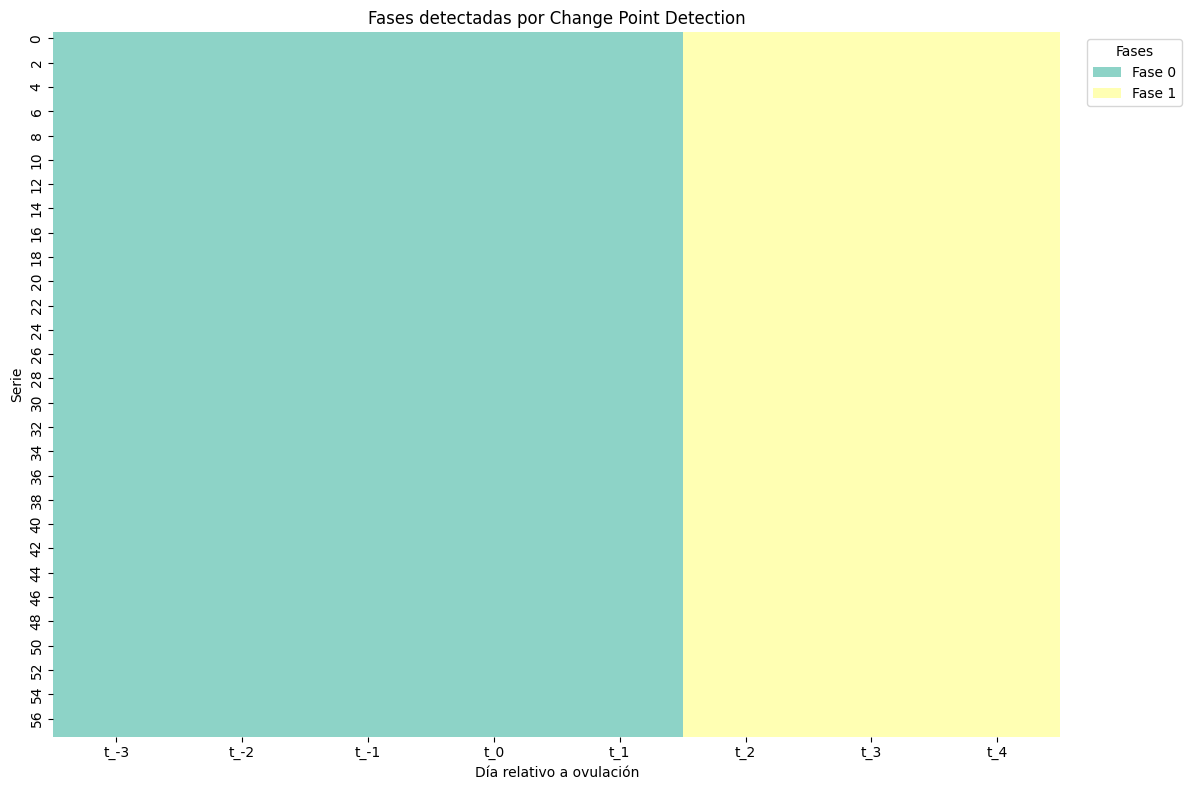

In [16]:
import ruptures as rpt

# df: tu DataFrame con 58 filas (series) y 24 columnas (8 días × 3 variables: max, mean, min)
# Ejemplo de nombres: t_0_max, t_0_mean, t_0_min, ..., t_7_max, t_7_mean, t_7_min

num_series = df_series.shape[0]
num_days = 8
variables_per_day = 3  # max, mean, min

# Convertir cada fila en una matriz (num_days, variables_per_day)
series_data = [df_series.iloc[i].values.reshape(num_days, variables_per_day) for i in range(num_series)]

# Detectar puntos de cambio por serie
all_cps = []
penalizacion = 0.01  # ajustar para más/fewer cambios detectados
num_cambios = 1

for serie in series_data:
    #algo = rpt.Pelt(model="l2").fit(serie) # rbf, l2, normal
    #cps = algo.predict(pen=penalizacion)
    algo = rpt.Binseg(model="rbf").fit(serie)
    cps = algo.predict(n_bkps=num_cambios)
    all_cps.append(cps)

# Crear matriz para fases: filas=series, columnas=días, valores=fase (estado entre puntos de cambio)
phases_matrix = np.zeros((num_series, num_days), dtype=int)

for i, cps in enumerate(all_cps):
    start = 0
    for phase_id, end in enumerate(cps):
        # end es índice +1, pero en Python es exclusivo, así que ajustamos:
        end_idx = min(end, num_days)
        phases_matrix[i, start:end_idx] = phase_id
        start = end_idx

# Etiquetas de días relativos
dias_labels = [f"t_{i}" for i in range(-3, 5)]

# Crear paleta de colores según número de fases detectadas
num_fases = phases_matrix.max() + 1
cmap = sns.color_palette("Set3", num_fases)

# Dibujar heatmap sin barra automática
plt.figure(figsize=(12, 8))
ax = sns.heatmap(phases_matrix, cmap=cmap, cbar=False, xticklabels=dias_labels)

plt.xlabel("Día relativo a ovulación")
plt.ylabel("Serie")
plt.title("Fases detectadas por Change Point Detection")

# Añadir leyenda personalizada
leyenda = [Patch(facecolor=cmap[i], label=f"Fase {i}") for i in range(num_fases)]
plt.legend(handles=leyenda, title="Fases", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

c:\Users\pablo\AppData\Local\Programs\Python\Python313\Lib\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


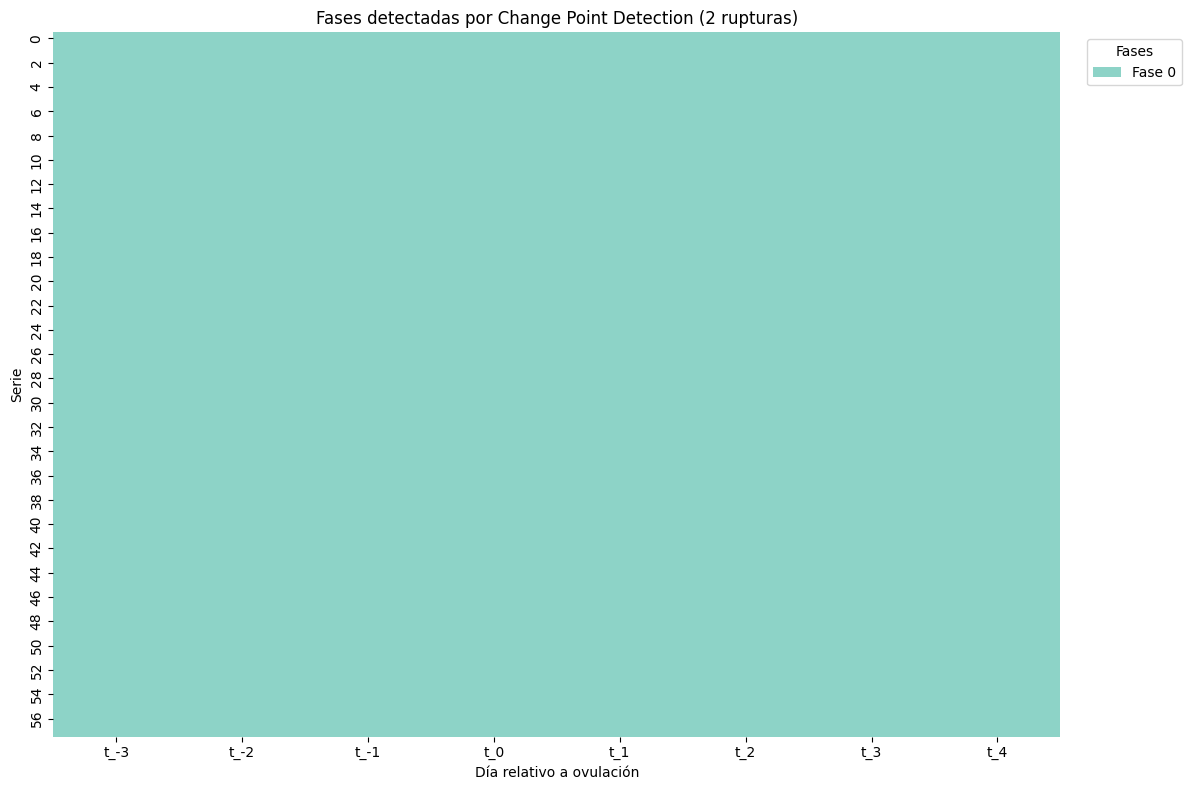

In [18]:
import ruptures as rpt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# df_series: tu DataFrame con 58 filas (series) y 24 columnas (8 días × 3 variables: max, mean, min)

num_series = df_series.shape[0]
num_days = 8
variables_per_day = 3  # max, mean, min

# Convertir cada fila en una matriz (num_days, variables_per_day)
series_data = [df_series.iloc[i].values.reshape(num_days, variables_per_day) for i in range(num_series)]

# Detectar dos puntos de cambio por serie
all_cps = []
num_cambios = 2  # dos puntos de ruptura

for serie in series_data:
    try:
        algo = rpt.Binseg(model="normal", min_size=1).fit(serie)
        cps = algo.predict(n_bkps=num_cambios)
    except rpt.exceptions.BadSegmentationParameters:
        # Si no se pueden detectar 2 rupturas, se asigna solo una ruptura al final
        cps = [num_days]
    all_cps.append(cps)

# Crear matriz para fases: filas=series, columnas=días, valores=fase (estado entre puntos de cambio)
phases_matrix = np.zeros((num_series, num_days), dtype=int)

for i, cps in enumerate(all_cps):
    start = 0
    for phase_id, end in enumerate(cps):
        end_idx = min(end, num_days)
        phases_matrix[i, start:end_idx] = phase_id
        start = end_idx

# Etiquetas de días relativos
dias_labels = [f"t_{i}" for i in range(-3, 5)]

# Crear paleta de colores según número de fases detectadas
num_fases = phases_matrix.max() + 1
cmap = sns.color_palette("Set3", num_fases)

# Dibujar heatmap sin barra automática
plt.figure(figsize=(12, 8))
ax = sns.heatmap(phases_matrix, cmap=cmap, cbar=False, xticklabels=dias_labels)

plt.xlabel("Día relativo a ovulación")
plt.ylabel("Serie")
plt.title("Fases detectadas por Change Point Detection (2 rupturas)")

# Añadir leyenda personalizada
leyenda = [Patch(facecolor=cmap[i], label=f"Fase {i}") for i in range(num_fases)]
plt.legend(handles=leyenda, title="Fases", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()
